In [1]:
library(ggplot2)
library(tibble)
library(microbenchmark)
library(matlib)

Warning message:
"package 'microbenchmark' was built under R version 4.1.3"
Warning message:
"package 'matlib' was built under R version 4.1.3"


In [11]:
is.character("10")

[1] TRUE

# LASSO optimization

We solve the familiar LASSO problem,
$$
\min_\beta \|X\beta-Y\|_2^2+\lambda\|\beta\|_1
$$
with a number of different algorithms:

- Proximal gradient descent
- Accelerated gradient descent
- Subgradient descent
- ADMM
- Coordinate descent


### Data generator

In [2]:
generate_data <- function(n=200, d=100, s=2, seed =42) 
{
    set.seed(seed)
    beta <- numeric(length = d)
    beta [1:s] <- 1
    X <- matrix(rnorm(n*d), nrow=n, ncol=d)
    y <- c(X %*% beta) + rnorm(n)
    list(X=X, y=y, beta=beta)
}
data <- generate_data(n=500, d=40, s=4, seed =58)
print("True beta")
data$beta

[1] "True beta"


[1] 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[39] 0 0

### Helpers

In [6]:
linspace <- function(x1, x2, n=100) {
    stopifnot(is.numeric(x1), is.numeric(x2), length(x1)==1, length(x2)==1)
    n <- floor(n)
    if (n <= 1) x2
    else seq(x1, x2, length.out=n)
}
hess.loss.max <- function(X)
{
    hess.loss = 2 * (t(X) %*% X)
    hess.ev = eigen(hess.loss)$values
    return(max(hess.ev))
}
l1.norm <- function(a) {sum(abs(a))}
l2.norm <- function(a) {sqrt(sum(a*a))}
loss.lasso <- function(X, y, beta, lam){0.5*l2.norm(X%*%beta-y)**2+lam*l1.norm(beta)}
backtrack <- function(f, grad, x, eta, k) 
{
    i <- 1
    alpha <- c(1)
    search_vec <- -grad
    t <- -k * t(search_vec)%*%grad
    while (f(x)-f(x+alpha[i]*search_vec)<alpha[i]*t)
    {
        alpha <- c(alpha, eta*alpha[i])
        i <- i+1
    }
    return(tail(alpha, 1))
}

### GD steps

In [4]:
gd_step.sub_grad <- function(X, y, beta_, t, lam) {beta_-t* (t(X)%*%(X%*%beta_-y)+lam*sign(beta_))}

In [5]:
prox.l1 <- function(x, lam){sign(x)*pmax(abs(x)-lam, 0)}
gd_step.prox <- function(X, y, beta_, t, lam) {prox.l1(beta_-t*t(X)%*%(X%*%beta_-y), lam*t)}

In [6]:
gd_step.acc_prox <- function(X, y, beta_, beta_prev, t, lam, k)
{
    v <- beta_+(k/(k+3))*(beta_-beta_prev)
    return(prox.l1(v-t*t(X)%*%(X%*%v-y), lam*t))
}

### Fitters

In [7]:
fit.lasso <- function(alg, X, y, 
                      beta_true=NULL, lam=3, max_iter=50, early_stop=0, eta=0.1, k=0.3, back_track=FALSE, t=1)
{
    d <- dim(X)[2]
    beta = numeric(length=d)
    betas = list(beta, beta)
    loss <- NULL
    error <- NULL
    iter <- 0
    t<-t/hess.loss.max(X)
    while(iter<max_iter)
    {
        iter <- iter+1
        y_hat <- X%*%beta
        if(back_track)
            {t<-backtrack(function(b){loss.lasso(X, y, b, lam)}, t(X)%*%(X%*%beta-y)+lam*sign(beta), beta, eta, k)}
        if(alg=='prox'){beta <- gd_step.prox(X, y, beta, t, lam)}
        else if(alg=='sub_grad'){beta <- gd_step.sub_grad(X, y, beta, t, lam)}
        else if(alg=='acc_prox')
        {
            betas <- append(betas, list(gd_step.acc_prox(X, y, rev(betas)[[1]], rev(betas)[[2]], t, lam, iter)))
            if(length(betas)>2){betas<-betas[-1]}
            beta <- rev(betas)[[1]]
        }
        else {stop('invalid algorithm')}
        loss <- c(loss, loss.lasso(X, y, beta, lam))
        if(!is.null(beta_true))
        {
            log_loss <- log(tail(loss, 1))-log(loss.lasso(X, y, beta_true, lam))
            error <- c(error, log_loss)
        }
        if(iter==early_stop){break}
    }
    return(list(y_pred=X%*%beta, beta=beta, loss=loss/length(y),  error=error))
}

In [ ]:
data <- generate_data(n=400, d=40, s=300, seed =58)
model.prox <- fit.lasso('prox', data$X, data$y, data$beta)
model.sub_grad <- fit.lasso('sub_grad', data$X, data$y, data$beta)
model.acc_prox <- fit.lasso('acc_prox', data$X, data$y, data$beta)

In [9]:
prox.overfit <- which.max(model.prox$error<0)
sub_grad.overfit <- which.max(model.sub_grad$error<0)
acc_prox.overfit <- which.max(model.acc_prox$error<0)

In [10]:
df <- tibble(n.iter = 1:length(model.prox$error) ,
prox.error = model.prox$error ,
sub_grad.error = model.sub_grad$error,
acc_prox.error = model.acc_prox$error)

null device 
          1

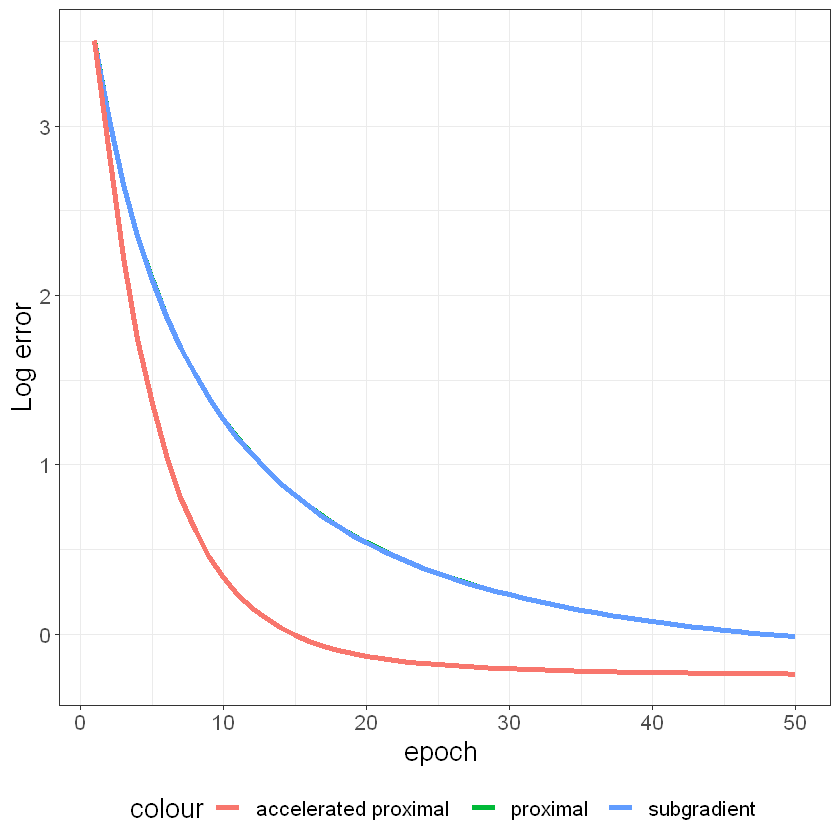

In [11]:
# pdf('30conv4.pdf', width=10, height =6)
ggplot(data=df, aes(x=n.iter)) +
geom_line(aes(y=prox.error , color='proximal'), lwd=1.5) +
geom_line(aes(y=sub_grad.error , color='subgradient'), lwd=1.5) +
geom_line(aes(y=acc_prox.error, color='accelerated proximal'), lwd=1.5) +
ylab('Log error') +
xlab('epoch ') +
theme_bw() +
theme(legend.position='bottom', text = element_text(size = 16))
dev.off()

In [12]:
L <- hess.loss.max(data$X)
1/L

[1] 0.0003254267

In [13]:
n.reps <- 1000
bench <- summary(microbenchmark(
    gd_step.prox(data$X, data$y, numeric(length=dim(data$X)[2]), 0.01, 1),
    gd_step.sub_grad(data$X, data$y, numeric(length=dim(data$X)[2]), 0.01, 1),
    gd_step.acc_prox(data$X, data$y, numeric(length=dim(data$X)[2]), numeric(length=dim(data$X)[2])+1/dim(data$X)[2],0.01, 0.1, 2),
    unit='ms',
    times=n.reps))

In [14]:
print(tibble(iter=bench$mean ,
overfit=c(prox.overfit , sub_grad.overfit, acc_prox.overfit),
total=c(prox.overfit *bench$mean[1],
sub_grad.overfit * bench$mean [2], acc_prox.overfit *bench$mean[3])))

# A tibble: 3 x 3
   iter overfit total
  <dbl>   <int> <dbl>
1 0.870      48  41.8
2 0.897      48  43.0
3 0.880      15  13.2


# ADMM and coordinate descent

## ADMM
We first write the problem as
$$
\min_{\beta,\gamma}\frac{1}{2}\|Y-X\beta\|^2_2+\lambda\|\gamma\|_1,\quad \beta=\gamma
$$
The augmented Lagrangian is
$$
L_\rho = \frac{1}{2}\|Y-X\beta\|^2_2+\lambda\|\gamma\|_1+\eta^T(\beta-\gamma)+\frac{\rho}{2}\|\beta-\gamma\|_2^2
$$
The specific ADMM updates are then
$$
\begin{aligned}
\beta &\leftarrow (X^TX+\rho I)^{-1}(X^Ty+\rho(\gamma-\eta))\\
\gamma&\leftarrow S_{\lambda/\rho}(\beta+\eta)\\
\eta&\leftarrow \eta+\beta-\gamma
\end{aligned}
$$
## Coordinate descent

For each component of the weight vector, do
$$
\beta_i \leftarrow S_{\lambda/\|X_i\|^2}\left(\frac{X_i^T(Y-X_{-i}\beta_{-i})}{X_i^TX_i}\right)
$$
where $X_{-i}$ excludes the $i-$th feature, which achieves
$$
\arg\min_{\beta_i} f(\beta_i,\beta_{-i})
$$

In [157]:
prox.l1 <- function(x, lam){sign(x)*pmax(abs(x)-lam, 0)}

admm_step <- function(X, y, beta_, gamma_, eta_, rho, lam)
{
    d <- dim(X)[2]
    beta_ <- inv(t(X)%*%X+rho*diag(d))%*%(t(X)%*%y+rho*(gamma_-eta_))
    gamma_ <- prox.l1(beta_+eta_, lam/rho)
    eta_ <- eta_+beta_-gamma_
    return(list(beta=beta_,gamma=gamma_, eta=eta_))
}

coordinate_step <- function(X, y, beta_, lam)
{
    for (i in 1:length(beta_))
    {
        coord <- X[, i]
        not.coord <- X[, -i]
        beta_[i] <- prox.l1(t(coord)%*%(y-not.coord%*%beta_[-i])/(t(coord)%*%coord), lam/l2.norm(coord)**2)
    }
    return(beta_)
}

In [158]:
fit.lasso.admm <- function(alg, X, y, beta_true, rho, lam, max_iter=50)
{
    d <- dim(X)[2]
    params <- list(beta=numeric(length=d), gamma=numeric(length=d), eta=numeric(length=d))
    beta <- params$beta
    loss <- NULL
    error <- NULL
    iter <- 0
    while(iter<max_iter)
    {
        iter <- iter+1
        if(alg=="ADMM")
            {
            params <- admm_step(X, y, params$beta, params$gamma,params$eta, rho, lam)
            beta <- params$beta
            }
        else if(alg=="coordinate")
            {beta <- coordinate_step(X, y, beta, lam)}
        loss <- c(loss, loss.lasso(X, y, beta, lam))
        error <- c(error, l2.norm(beta_true-beta))
        
    }
    return(list(y_pred=X%*%beta, beta=beta, loss=loss/length(y), error=error))
}

In [163]:
model.admm <- fit.lasso.admm("ADMM", data$X, data$y,data$beta, 3, 1, max_iter=40)
model.coordinate <- fit.lasso.admm("coordinate", data$X, data$y,data$beta, .1, 1, max_iter=40)

In [164]:
df <- tibble(n.iter = 1:length(model.admm$error) ,
admm.error = model.admm$error,
coordinate.error = model.coordinate$error)
# acc_prox.error = model.acc_prox$error)


null device 
          1

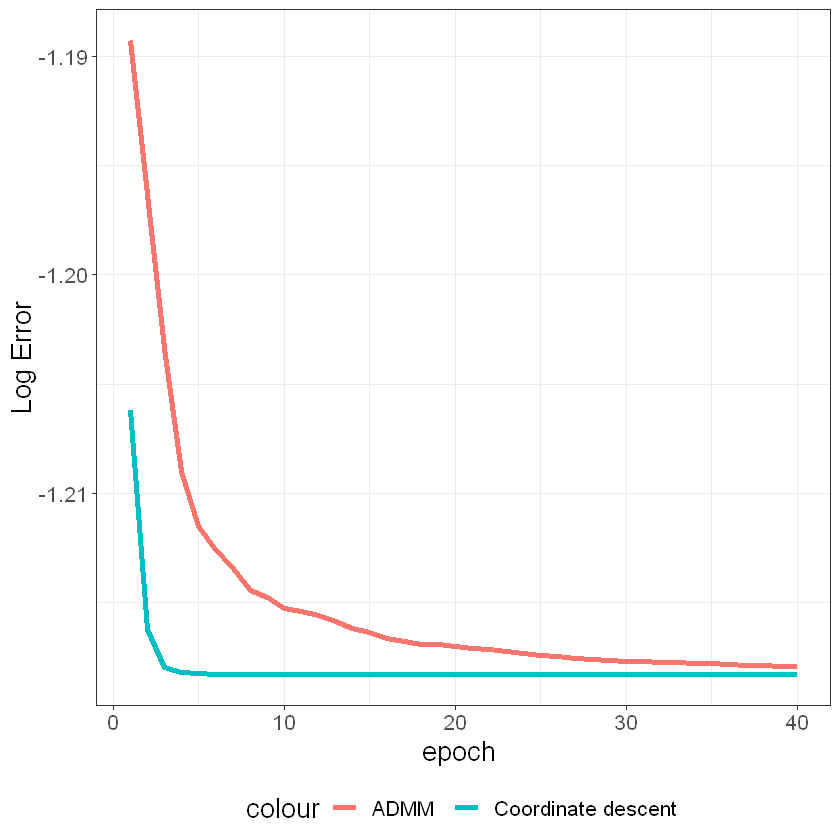

In [167]:
# pdf('corrd_vs_admm.pdf', width=10, height =6)
ggplot(data=df, aes(x=n.iter)) +
geom_line(aes(y=log(admm.error) , color='ADMM'), lwd=1.5) +
geom_line(aes(y=log(coordinate.error) , color='Coordinate descent'), lwd=1.5) +
ylab('Log Error') +
xlab('epoch ') +
theme_bw() +
theme(legend.position='bottom', text = element_text(size = 16))
dev.off()